# 시계열 분석 연구과제
## 문제 2


born_baby 데이터는 2000년 01월부터 2022년 12월까지 전국에서 출생한 신생아 수를 조사하여, 시·도별로 표시한 자료의 일부이다.

아래 표는 해당 자료의 일부를 나타낸 것이다.

시점	서울특별시	부산광역시	대구광역시	인천광역시
2022년 08월	3,670	1,249	854	1,265
2022년 09월	3,651	1,209	863	1,262
2022년 10월	3,612	1,166	848	1,200
2022년 11월	3,230	977	802	1,130
2022년 12월	2,901	957	663	1,018

이 데이터를 활용하여 조사기간 동안 전국 평균 신생아 수가 어떻게 변화하고 있는지 분석하고, 앞으로 5년간의 신생아 수를 전국 평균 단위로 예측한 자료를 시각화하시오.

※ 단, 조사되지 않은 항목에 대해서는 신생아 수가 0인 것으로 간주한다.

### #01. 준비작업
#### 1. 라이브러리 가져오기

In [16]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame,to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import pandas as pd



# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# 데이터 정상성 확인을 위한 ADF 검정
from statsmodels.tsa.stattools import adfuller




# ACF, PACF 테스트
from statsmodels.tsa.stattools import acf, pacf

# ACF, PACF 시각화 기능
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



### 차분 처리 함수

In [7]:
def diff(df, yname):
    diff_df = df.copy()
    diff_count = 0          # 몇 번 차분했는지
    result = []             # ADF 결과 저장 리스트

    while True:
        ar = adfuller(diff_df[yname])

        ar_dict = {
            '차수': diff_count,
            'ADF Statistic': ar[0],
            'p-value': ar[1],
            'result': True if ar[1] <= 0.05 else False
        }

        # 결과 저장
        result.append(ar_dict)

        # 정상성 만족 시 종료
        if ar_dict['result']:
            return pd.DataFrame(result), diff_df

        # 정상성 불만족 → 차분 수행
        diff_count += 1
        diff_df = diff_df.diff().dropna()


### ACF - PACF 일괄 처리

In [8]:

def acf_pacf(df, yname, my_dpi=100):
    """
    ACF/PACF를 계산하고, 유의구간(±2/sqrt(N)) 기준으로
    '연속 유의 구간이 끝나는 지점'을 q(ACF), p(PACF) 후보로 뽑아 시각화 후 반환.

    Returns
    -------
    (p_candidate, q_candidate)
    """
    diff_df = df.copy()

    # =====================
    # ACF
    # =====================
    # 1) ACF 계산
    acf_vals = acf(diff_df[yname])
    threshold = 2 / np.sqrt(len(diff_df[yname]))

    # 2) 결과표 생성
    df_acf = pd.DataFrame({
        "lag": np.arange(len(acf_vals)),
        "acf": acf_vals,
    })

    # 3) 유의성 판단
    df_acf["abs_acf"] = df_acf["acf"].abs()
    df_acf["significant"] = df_acf["abs_acf"] > threshold

    # 4) 보기 좋게 정리
    df_acf["acf"] = df_acf["acf"].round(3)
    df_acf["abs_acf"] = df_acf["abs_acf"].round(3)
    df_acf["threshold"] = round(threshold, 3)

    # 5) lag=0 제외 (파점용)
    df_acf_result = df_acf.query("lag > 0").reset_index(drop=True)

    # 6) 연속 유의 구간 계산
    df_acf_result["prev_significant"] = df_acf_result["significant"].shift(1)

    df_acf_result["cut_candidate"] = (
        (df_acf_result["prev_significant"] == True) &
        (df_acf_result["significant"] == False)
    )

    # 7) q값 후보
    if df_acf_result["cut_candidate"].any():
        q_candidate = (
            df_acf_result.loc[df_acf_result["cut_candidate"], "lag"].min() - 1
        )
    else:
        # 끝까지 계속 유의하거나, 처음부터 유의가 거의 없으면 fallback
        q_candidate = int(df_acf_result.loc[df_acf_result["significant"], "lag"].max()) \
            if df_acf_result["significant"].any() else 0

    # =====================
    # PACF
    # =====================
    # 1) PACF 계산
    pacf_vals = pacf(diff_df[yname])
    threshold = 2 / np.sqrt(len(diff_df[yname]))

    # 2) 결과표 생성
    df_pacf = pd.DataFrame({
        "lag": np.arange(len(pacf_vals)),
        "pacf": pacf_vals,
    })

    # 3) 유의성 판단
    df_pacf["abs_pacf"] = df_pacf["pacf"].abs()
    df_pacf["significant"] = df_pacf["abs_pacf"] > threshold

    # 4) 보기 좋게 정리
    df_pacf["pacf"] = df_pacf["pacf"].round(3)
    df_pacf["abs_pacf"] = df_pacf["abs_pacf"].round(3)
    df_pacf["threshold"] = round(threshold, 3)

    # 5) lag=0 제외
    df_pacf_result = df_pacf.query("lag > 0").reset_index(drop=True)

    # 6) 연속 유의구간 계산
    df_pacf_result["prev_significant"] = df_pacf_result["significant"].shift(1)

    df_pacf_result["cut_candidate"] = (
        (df_pacf_result["prev_significant"] == True) &
        (df_pacf_result["significant"] == False)
    )

    # 7) p값 후보
    if df_pacf_result["cut_candidate"].any():
        p_candidate = (
            df_pacf_result.loc[df_pacf_result["cut_candidate"], "lag"].min() - 1
        )
    else:
        p_candidate = int(df_pacf_result.loc[df_pacf_result["significant"], "lag"].max()) \
            if df_pacf_result["significant"].any() else 0

    # =====================
    # 서브플롯 시각화
    # =====================
    width_px = 2000
    height_px = 1500
    rows = 2
    cols = 1
    figsize = (width_px / my_dpi, height_px / my_dpi)

    fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

    # 2-1) ACF plot
    plot_acf(diff_df[yname], ax=ax[0])

    # 2-2) MA(q) 후보 시각화
    ax[0].axvline(
        x=q_candidate,
        linestyle="--",
        linewidth=1.5,
        alpha=0.8,
        color="red",
    )
    ax[0].text(
        q_candidate + 0.1,
        ax[0].get_ylim()[1] * 0.9,
        f"MA(q) candidate = {q_candidate}",
        fontsize=9,
        verticalalignment="top"
    )

    ax[0].set_title("ACF Plot", fontsize=12, pad=8)
    ax[0].set_xlabel("Lag", fontsize=8, labelpad=5)
    ax[0].set_ylabel("Autocorrelation", fontsize=8, labelpad=5)
    ax[0].grid(True, alpha=0.3)

    # 3-1) PACF plot
    plot_pacf(diff_df[yname], ax=ax[1])

    # 3-2) AR(p) 후보 시각화
    ax[1].axvline(
        x=p_candidate,
        linestyle="--",
        linewidth=1.5,
        alpha=0.8,
        color="red",
    )
    ax[1].text(
        p_candidate + 0.1,
        ax[1].get_ylim()[1] * 0.9,
        f"AR(p) candidate = {p_candidate}",
        fontsize=9,
        verticalalignment="top"
    )

    ax[1].set_title("PACF Plot", fontsize=12, pad=8)
    ax[1].set_xlabel("Lag", fontsize=8, labelpad=5)
    ax[1].set_ylabel("Partial Autocorrelation", fontsize=8, labelpad=5)
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

    return p_candidate, q_candidate


### ARIMA 수행 함수

In [9]:
def arima(df, yname, p, d, q, s=None):
    """
    (p,d,q) 범위를 0~p, 0~d, 0~q로 그리드 서치해서
    수렴(converged)한 모델만 AIC/BIC를 저장하고,
    BIC(우선) -> AIC 순으로 가장 좋은 모델 1개를 반환.

    s가 None/0이면 비계절 ARIMA,
    s가 주어지면 seasonal_order=(x,y,z,s)로 SARIMA 형태로 적합.
    """
    # NaN 들어오면 0으로 처리 (스크린샷 로직 반영)
    p = 0 if pd.isna(p) else int(p)
    d = 0 if pd.isna(d) else int(d)
    q = 0 if pd.isna(q) else int(q)
    s = 0 if pd.isna(s) else int(s)

    results = []  # 결과 저장

    for x in range(0, p + 1):
        for y in range(0, d + 1):
            for z in range(0, q + 1):
                try:
                    if not s:
                        print(f"p={x}, d={y}, q={z}")
                        model = ARIMA(df[yname], order=(x, y, z))
                    else:
                        print(f"p={x}, d={y}, q={z}, s={s}")
                        # statsmodels ARIMA의 seasonal_order는 (P,D,Q,s) 형태
                        model = ARIMA(df[yname], order=(x, y, z), seasonal_order=(x, y, z, s))

                    fit = model.fit()

                    # 수렴 실패 모델 제외
                    if (hasattr(fit, "mle_retvals")
                        and isinstance(fit.mle_retvals, dict)
                        and (not fit.mle_retvals.get("converged", True))):
                        continue

                    results.append({
                        "p": x,
                        "d": y,
                        "q": z,
                        "AIC": fit.aic,
                        "BIC": fit.bic
                    })

                except Exception:
                    # 수렴 실패/모델 오류는 건너뜀
                    continue

    df_results = DataFrame(results)

    if df_results.empty:
        # 후보가 하나도 없으면 빈 결과 반환
        return df_results, None

    best_model = df_results.sort_values(["BIC", "AIC"]).iloc[0]

    return df_results, best_model


#### 2. 시각화 초기화

In [10]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

### ARIMA 결과 해석 함수

In [11]:
def arima_report(fit, data, threshold=0.05):
    """
    SARIMAXResults 객체(fit)와 원본 데이터(data)를 받아
    - 모형 적합도 표(cdf)
    - 계수 요약 표(rdf)
    - 모형 요약 문장(result_report)
    - 모형 판정 문장(model_report)  (Ljung-Box로 잔차 자기상관 확인)
    - 계수별 해석 문장(variable_reports)
    를 반환한다.
    """

    # ------------------------------
    # 모형 적합도 요약
    # ------------------------------
    cdf = DataFrame({
        "Log Likelihood": [fit.llf],
        "AIC": [fit.aic],
        "BIC": [fit.bic],
        "HQIC": [getattr(fit, "hqic", np.nan)],
        "관측치 수": [fit.nobs],
    })

    # ------------------------------
    # 계수 테이블 구성
    # ------------------------------
    params = fit.params
    bse = fit.bse
    zvals = params / bse
    pvals = fit.pvalues
    conf = fit.conf_int()

    rows = []
    for name in params.index:
        p = float(pvals[name])
        stars = (
            "***" if p < 0.001 else
            "**"  if p < 0.01 else
            "*"   if p < 0.05 else
            ""
        )

        rows.append({
            "변수": name,
            "계수": float(params[name]),
            "표준오차": float(bse[name]),
            "z": f"{float(zvals[name]):.3f}{stars}",
            "p-value": p,
            "CI_lower": float(conf.loc[name, 0]),
            "CI_upper": float(conf.loc[name, 1]),
        })

    rdf = DataFrame(rows)

    # ------------------------------
    # 모형 요약 문장
    # ------------------------------
    result_report = (
        f"Log Likelihood = {fit.llf:.3f}, "
        f"AIC = {fit.aic:.3f}, "
        f"BIC = {fit.bic:.3f}."
    )

    # ------------------------------
    # 모형 판정 문장 (Ljung-Box)
    # ------------------------------
    # statsmodels 버전에 따라 결과 형태가 달라 p-value 추출을 안전하게 처리
    lb_pvalue = None
    try:
        lb = fit.test_serial_correlation(method="ljungbox")

        # 1) DataFrame 형태인 경우(많음): 컬럼에 'lb_pvalue' 또는 'pvalue'
        if isinstance(lb, pd.DataFrame):
            if "lb_pvalue" in lb.columns:
                lb_pvalue = float(lb["lb_pvalue"].iloc[-1])
            elif "pvalue" in lb.columns:
                lb_pvalue = float(lb["pvalue"].iloc[-1])

        # 2) dict / list / tuple 형태 대응
        elif isinstance(lb, dict):
            if "lb_pvalue" in lb:
                lb_pvalue = float(np.array(lb["lb_pvalue"])[-1])
            elif "pvalue" in lb:
                lb_pvalue = float(np.array(lb["pvalue"])[-1])

        # 3) tuple/list로 (stat, pvalue, ...) 반환하는 경우
        elif isinstance(lb, (list, tuple, np.ndarray)):
            # 스샷 로직처럼 마지막 원소를 p-value로 가정
            try:
                lb_pvalue = float(lb[0][-1])
            except Exception:
                pass

    except Exception:
        lb_pvalue = None

    model_report = (
        f"ARIMA{getattr(fit.model, 'order', '')}"
        f"{getattr(fit.model, 'seasonal_order', '')} 모형을 적합한 결과, "
        f"AIC {fit.aic:.3f}, BIC {fit.bic:.3f}로 나타났으며 "
    )

    if lb_pvalue is None:
        model_report += (
            "잔차의 자기상관(Ljung-Box) 검정을 수행했으나 p-value를 추출하지 못했습니다. "
            "statsmodels 버전을 확인하거나 lb 결과를 직접 출력해 확인해 주세요."
        )
    elif lb_pvalue > threshold:
        model_report += (
            "잔차들 사이에 특별한 시간적 패턴은 관찰되지 않음을 통계적으로 확인하였다. "
            "(잔차의 자기상관이 Ljung-Box 검정에서 유의하지 않았다)"
        )
    else:
        model_report += (
            "잔차들 사이에 시간적 패턴이 남아 있는 것으로 나타났으며, "
            "모형이 충분히 설명하지 못했을 가능성이 있다. "
            "(잔차의 자기상관이 Ljung-Box 검정에서 통계적으로 유의하다)"
        )

    # ------------------------------
    # 계수별 해석 문장 (시계열 특성 포함)
    # ------------------------------
    variable_reports = []

    for _, row in rdf.iterrows():
        name = row["변수"]

        if name == "const":
            continue

        coef = float(row["계수"])
        pval = float(row["p-value"])

        # 변수 유형 해석
        if name.startswith("ar.S"):
            meaning = "한 시즌 전 같은 시점의 값이 현재 값에 미치는 영향"
        elif name.startswith("ma.S"):
            meaning = "한 시즌 전 같은 시점에서 발생한 예측 오차가 현재에 남긴 영향"
        elif name.startswith("ar."):
            meaning = "직전 시점의 값이 현재 값에 미치는 영향"
        elif name.startswith("ma."):
            meaning = "직전 시점에서 발생한 예측 오차가 현재에 남긴 영향"
        elif name == "const":
            meaning = "전체 시계열의 기본 수준"
        else:
            meaning = "시계열의 특정 구조적 요소"

        # 방향 해석
        if coef > 0:
            direction = "값을 높이는 방향"
        elif coef < 0:
            direction = "값을 낮추는 방향"
        else:
            direction = "뚜렷한 방향성은 없음"

        # 통계적 유의성
        if pval < threshold:
            stat_text = "통계적으로 의미가 있다"
            plain_text = "우연이 아니라 반복되는 패턴일 가능성이 높다"
        else:
            stat_text = "통계적으로 뚜렷하지 않다"
            plain_text = "우연에 의한 나타났을 가능성을 배제하기 어렵다"

        variable_reports.append(
            f"{name}의 계수는 {coef:.3f}로 {stat_text} (p "
            f"{'<' if pval < threshold else '>'} {threshold}). "
            f"{meaning}로, 이 영향은 현재 값의 흐름을 {direction} 작용하며 "
            f"{plain_text}."
        )

    return cdf, rdf, result_report, model_report, variable_reports


#### 3. 데이터 가져오기

In [12]:
origin = load_data('born_baby')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


[data] https://data.hossam.kr/data/lab13_/born_baby.xlsx
[desc] 2000년 1월부터 2022년 12월까지 시단위 출생자 수 (출처: 국가통계포털)
[!] Cannot read metadata

==== 데이터 크기 확인 ====
데이터셋 크기: (276, 18)
열 개수: 18
행 개수: 276

==== 타입확인 ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   시점       276 non-null    object
 1   서울특별시    276 non-null    int64 
 2   부산광역시    276 non-null    int64 
 3   대구광역시    276 non-null    int64 
 4   인천광역시    276 non-null    int64 
 5   광주광역시    276 non-null    int64 
 6   대전광역시    276 non-null    int64 
 7   울산광역시    276 non-null    int64 
 8   세종특별자치시  276 non-null    int64 
 9   경기도      276 non-null    int64 
 10  강원도      276 non-null    int64 
 11  충청북도     276 non-null    int64 
 12  충청남도     276 non-null    int64 
 13  전라북도     276 non-null    int64 
 14  전라남도     276 non-null    int64 
 15  경상북도     276 non-null    int64 
 16  경상남도     276 n

In [13]:
origin.head()

,시점,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
0,2000년 01월,12866,3752,3057,3320,2159,1859,1479,0,13527,1966,1903,2398,2547,2679,3362,3928,842
1,2000년 02월,11797,3632,2698,3069,1916,1752,1388,0,12437,1780,1722,2273,2296,2366,3221,3612,764
2,2000년 03월,12453,3935,3057,3267,1893,1835,1524,0,13157,1803,1805,2269,2384,2423,3292,3972,809
3,2000년 04월,10782,3464,2753,2683,1773,1690,1360,0,11698,1612,1647,2076,2054,2157,2968,3661,680
4,2000년 05월,10817,3511,2785,2782,1698,1599,1311,0,11362,1615,1652,1988,2041,2109,2973,3516,733


- 전국 신생아 수 컬럼 하나 만들어주기

In [17]:
import pandas as pd

df = origin.copy()

# 1) 시점을 인덱스로
df['시점'] = to_datetime(df['시점'],format = '%Y년 %m월')
df = df.set_index('시점')

# 2) 결측은 0
df = df.fillna(0)

# 3) 전국 합계 컬럼 추가
df['전국'] = df.sum(axis=1)

df.head()


,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도,전국
시점,,,,,,,,,,,,,,,,,,
2000-01-01,12866,3752,3057,3320,2159,1859,1479,0,13527,1966,1903,2398,2547,2679,3362,3928,842,61644
2000-02-01,11797,3632,2698,3069,1916,1752,1388,0,12437,1780,1722,2273,2296,2366,3221,3612,764,56723
2000-03-01,12453,3935,3057,3267,1893,1835,1524,0,13157,1803,1805,2269,2384,2423,3292,3972,809,59878
2000-04-01,10782,3464,2753,2683,1773,1690,1360,0,11698,1612,1647,2076,2054,2157,2968,3661,680,53058
2000-05-01,10817,3511,2785,2782,1698,1599,1311,0,11362,1615,1652,1988,2041,2109,2973,3516,733,52492


- 데이터 전처리 

In [ ]:
national = df[['전국']]


national

,전국
시점,
2000년 01월,61644
2000년 02월,56723
2000년 03월,59878
2000년 04월,53058
2000년 05월,52492
...,...
2022년 08월,21782
2022년 09월,21918
2022년 10월,20646


### 데이터 정상성 확인

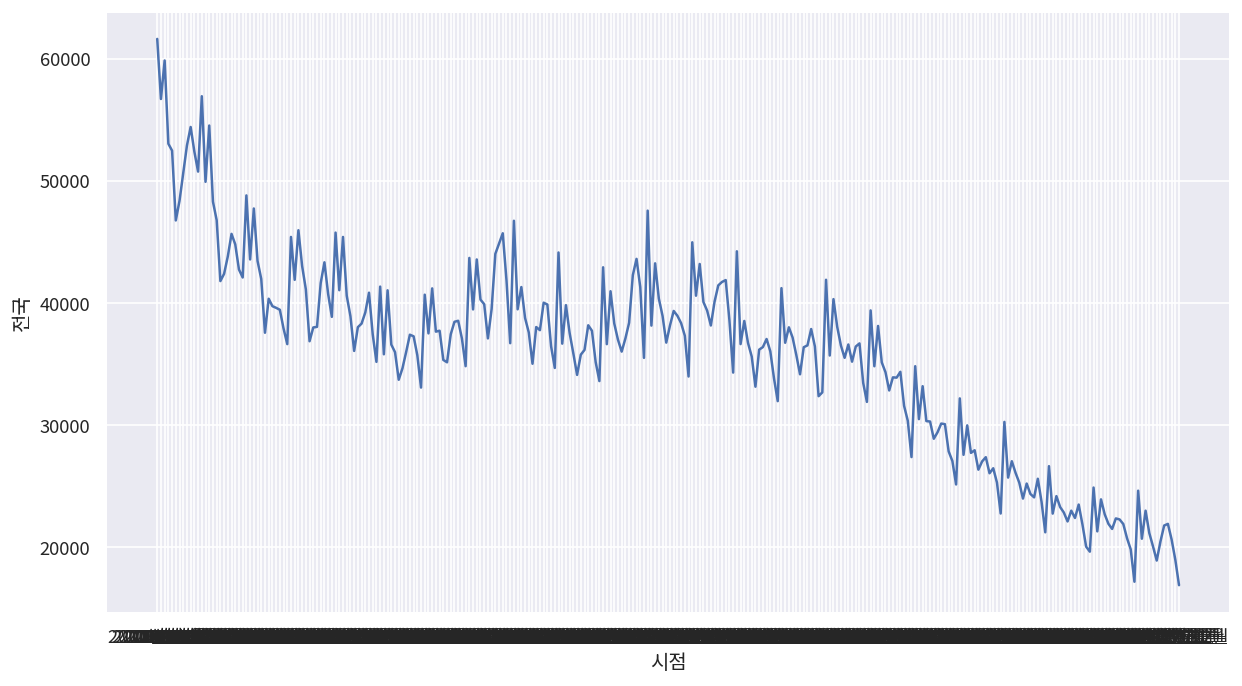

In [ ]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.lineplot(
    data=national, x=national.index, y='전국',
)

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김


# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


In [ ]:
ar = adfuller(national['전국'])
ar

(np.float64(-0.9211528613779406),
 np.float64(0.7809266912471355),
 15,
 260,
 {'1%': np.float64(-3.4557539868570775),
  '5%': np.float64(-2.8727214497041422),
  '10%': np.float64(-2.572728476331361)},
 np.float64(4449.946400401124))

In [ ]:
print('검정통계량 ADF statistic : %f'%ar[0])
print('유의수준 p-value : %f'%ar[1])
print('최적차수 (num of lags): %f' %ar[2])
print('관측치 개수 (num of observations) : %f' %ar[3])
print('기각값 (critical values)')
for key,value in ar[4].items():
  print('\t%s : %.3f' %(key,value))


print('데이터 정상성 여부 : ', ' 정상성 충족' if ar[1] <= 0.05 else '정상성 충족 안함')

검정통계량 ADF statistic : -0.921153
유의수준 p-value : 0.780927
최적차수 (num of lags): 15.000000
관측치 개수 (num of observations) : 260.000000
기각값 (critical values)
	1% : -3.456
	5% : -2.873
	10% : -2.573
데이터 정상성 여부 :  정상성 충족 안함


> 딱봐도 비정상성 이므로 차분을 해줘야겠따!!

In [ ]:
df_1차_차분 = national.diff().dropna()
df_1차_차분

,전국
시점,
2000년 02월,-4921.0
2000년 03월,3155.0
2000년 04월,-6820.0
2000년 05월,-566.0
2000년 06월,-5718.0
...,...
2022년 08월,1307.0
2022년 09월,136.0
2022년 10월,-1272.0


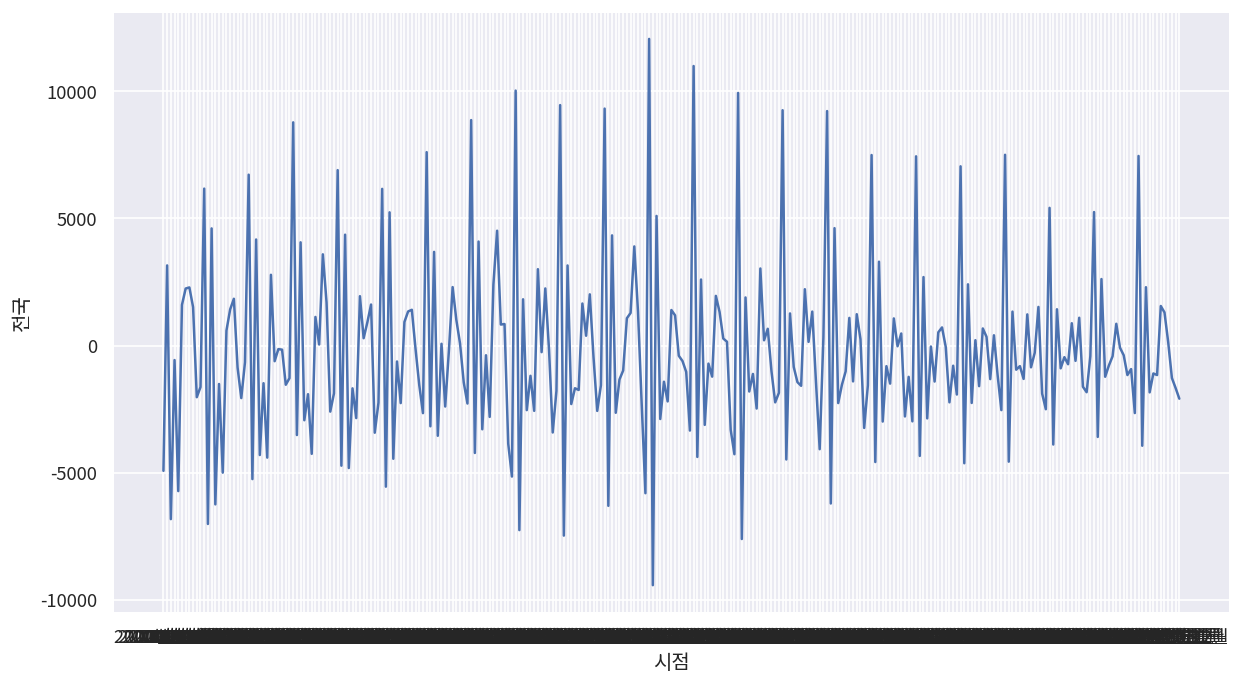

검정통계량 ADF statistic : -3.564043
유의수준 p-value : 0.006487
최적차수 (num of lags): 16.000000
관측치 개수 (num of observations) : 258.000000
기각값 (critical values)
	1% : -3.456
	5% : -2.873
	10% : -2.573
데이터 정상성 여부 :   정상성 충족


In [ ]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.lineplot(
    data=df_1차_차분, x=df_1차_차분.index, y='전국',
)

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김


# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료

ar = adfuller(df_1차_차분['전국'])
ar


print('검정통계량 ADF statistic : %f'%ar[0])
print('유의수준 p-value : %f'%ar[1])
print('최적차수 (num of lags): %f' %ar[2])
print('관측치 개수 (num of observations) : %f' %ar[3])
print('기각값 (critical values)')
for key,value in ar[4].items():
  print('\t%s : %.3f' %(key,value))


print('데이터 정상성 여부 : ', ' 정상성 충족' if ar[1] <= 0.05 else '정상성 충족 안함')


### 평균이동법

In [ ]:
df2 = df_1차_차분.copy()

df2['rolling3'] = df2['전국'].rolling(3).mean()
df2['rolling6'] = df2['전국'].rolling(6).mean()
df2['rolling9'] = df2['전국'].rolling(9).mean()



df2.head(10)

,전국,rolling3,rolling6,rolling9
시점,,,,
2000년 02월,-4921.0,NaN,NaN,NaN
2000년 03월,3155.0,NaN,NaN,NaN
2000년 04월,-6820.0,-2862.000000,NaN,NaN
2000년 05월,-566.0,-1410.333333,NaN,NaN
2000년 06월,-5718.0,-4368.000000,NaN,NaN
2000년 07월,1603.0,-1560.333333,-2211.166667,NaN
2000년 08월,2246.0,-623.000000,-1016.666667,NaN
2000년 09월,2290.0,2046.333333,-1160.833333,NaN
2000년 10월,1516.0,2017.333333,228.500000,-801.666667


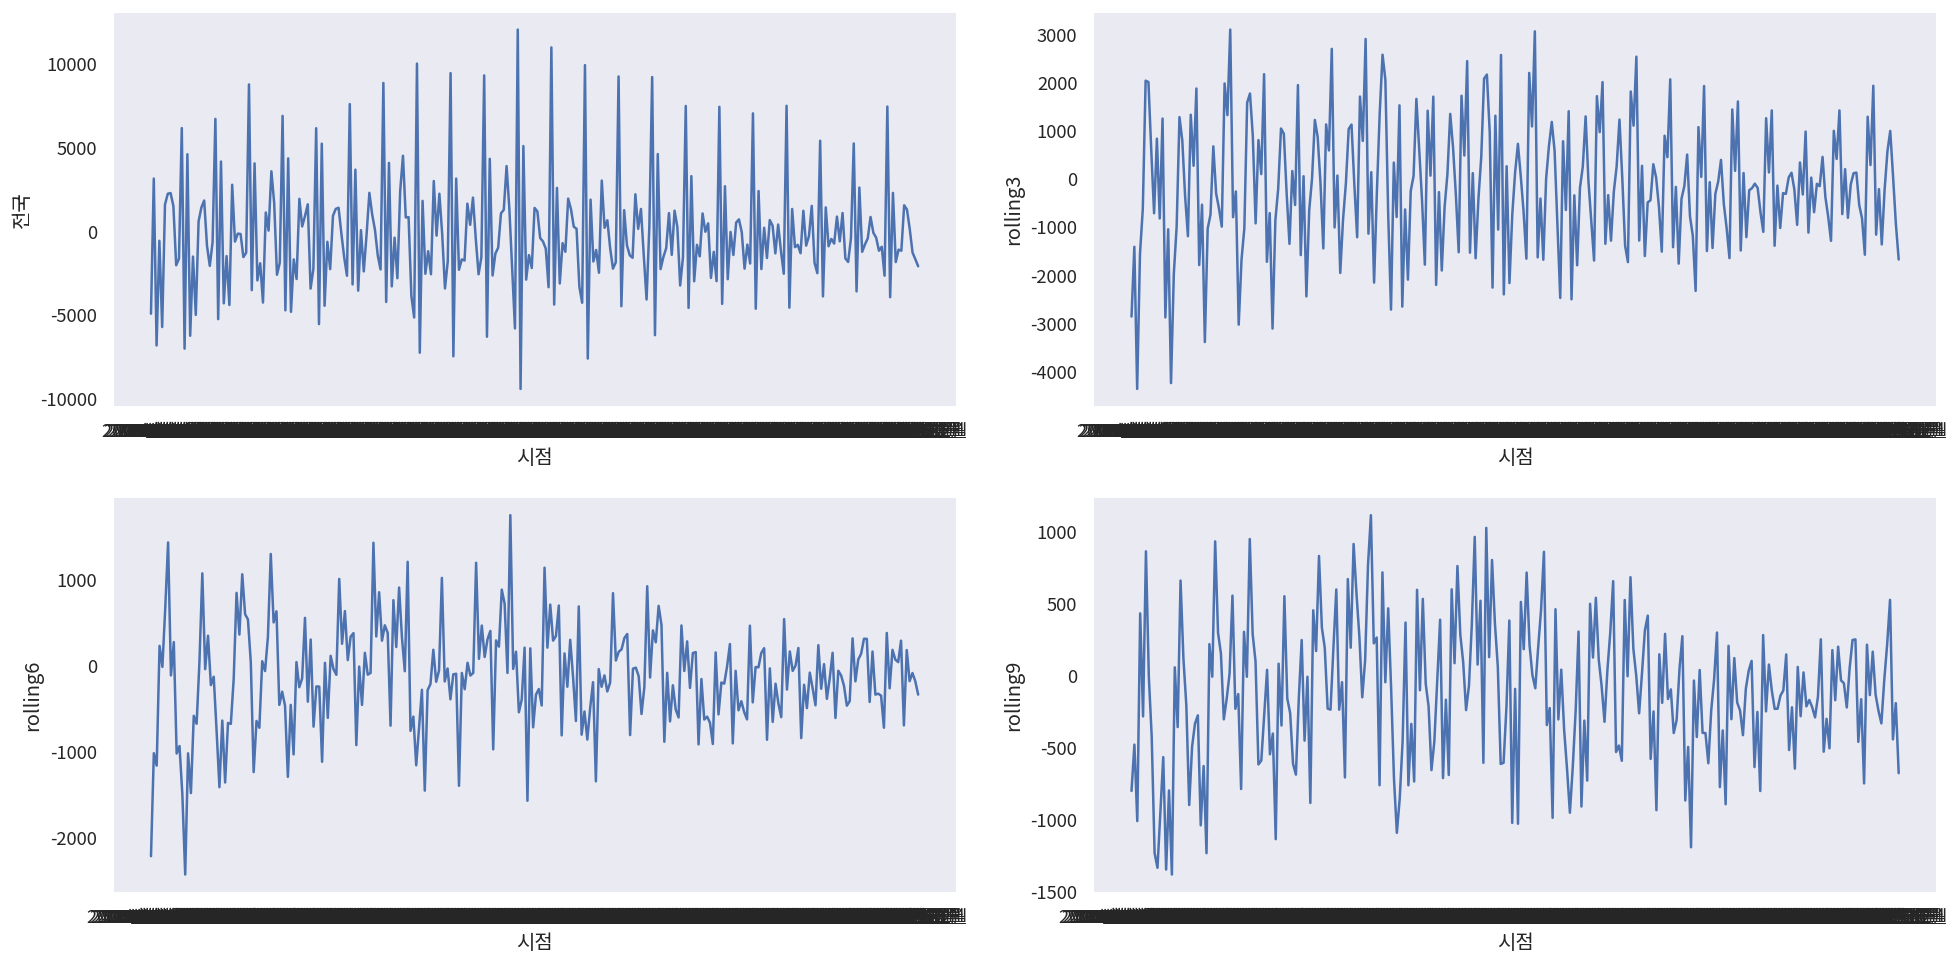

In [ ]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2000              # 그래프 가로 크기
height_px = 1000              # 그래프 세로 크기
rows = 2                     # 그래프 행 수
cols = 2                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용

sb.lineplot(df2,x=df2.index,y='전국',ax=ax[0][0])
sb.lineplot(df2,x=df2.index,y='rolling3',ax=ax[0][1])
sb.lineplot(df2,x=df2.index,y='rolling6',ax=ax[1][0])
sb.lineplot(df2,x=df2.index,y='rolling9',ax=ax[1][1])  


# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


In [ ]:
# 목적 : 과거 몇 시점(lag) 까지 현재에 영향을 주는지 자동으로 찾기

# 1. 차분된 시계열의 자기상관계수 (ACF) 계산 (lag 0 부터 시작)
acf_vals = acf(df2['전국'])  #이미 차분된 시계열 데이터를 acf()함수로 자기상관계수를 모두 계산한다 , 즉 지금 값이 과거의 나와 얼마나 닮았는지 숫자로 나타낸 것 


# 2. ACF 유의성 판단 기준 (근사적 95% 신뢰구간)
threshold = 2 / np.sqrt(len(df2['전국']))


# 3. 임계값을 초과하는 (유의한) lag 인덱스 추출
significant_lags = np.where (np.abs(acf_vals) >  threshold)[0]  

# 절대값을 씌워서 자기상관계수가 음이든 양이든 상관없이 크기만 보고, 위에서 구한 신뢰구간을 초과하는지 T/ F 로 확인 거기에서 0 번째, 즉 LAG 번호만뽑아내는 것
#WHERE는 TRUE 인 위치만 가져옴


# 4. 결과 확인
acf_vals,threshold,significant_lags


(array([ 1.        , -0.54652727,  0.24246347, -0.20950972,  0.0360589 ,
        -0.10764269,  0.25252945, -0.12377087,  0.0547765 , -0.22690141,
         0.24133583, -0.52382642,  0.88874298, -0.5186959 ,  0.22363828,
        -0.19857183,  0.04594377, -0.07871534,  0.23882497, -0.12937841,
         0.06694822, -0.23562722,  0.23367636, -0.49897455,  0.83293694]),
 np.float64(0.12060453783110543),
 array([ 0,  1,  2,  3,  6,  7,  9, 10, 11, 12, 13, 14, 15, 18, 19, 21, 22,
        23, 24]))

In [ ]:
# 1) ACF 계산
acf_vals = acf(df2['전국'])    #차분된 시계열에서 자기상관계쑤 ACF 를 계산해 배열로 저장
threshold = 2 / np.sqrt(len(df2['전국']))   #유의수준기준선

# 2) 결과표 생성   > 결과표 데이터 프레임 만들기 / lag 별 acf 값
df_acf = DataFrame({
    "lag": np.arange(len(acf_vals)),
    "acf": acf_vals,
})

# 3) 유의성 판단
df_acf["abs_acf"] = df_acf["acf"].abs()  #상관 방향 무시하고 크기만으로 확인
df_acf["significant"] = df_acf["abs_acf"] > threshold

# 4) 보기 좋게 정리
df_acf["acf"] = df_acf["acf"].round(3)
df_acf["abs_acf"] = df_acf["abs_acf"].round(3)
df_acf["threshold"] = round(threshold, 3)

# 5) lag=0 제외 (판정용)   > lag=0 인 경우는 자기 자신과의 비교라서 항상 1, 분석 방해함
df_acf_result = df_acf.query("lag > 0").reset_index(drop=True)

# 6) 연속 유의 구간 계산 > cut_candidate 만들기 , 즉 끊기는 지점 ㅈ찾기
df_acf_result["prev_significant"] = df_acf_result["significant"].shift(1)    #값을 한 칸 아래로 미는 것

df_acf_result["cut_candidate"] = (
    (df_acf_result["prev_significant"] == True) &
    (df_acf_result["significant"] == False)
)

df_acf_result[["lag", "acf", "significant", "cut_candidate"]]

df_acf_result



,lag,acf,abs_acf,significant,threshold,prev_significant,cut_candidate
0,1,-0.547,0.547,True,0.121,NaN,False
1,2,0.242,0.242,True,0.121,True,False
2,3,-0.210,0.210,True,0.121,True,False
3,4,0.036,0.036,False,0.121,True,True
4,5,-0.108,0.108,False,0.121,False,False
5,6,0.253,0.253,True,0.121,False,False
6,7,-0.124,0.124,True,0.121,True,False
7,8,0.055,0.055,False,0.121,True,True
8,9,-0.227,0.227,True,0.121,False,False
9,10,0.241,0.241,True,0.121,True,False


In [ ]:
q_candidate = (
  df_acf_result.loc[df_acf_result['cut_candidate'] , 'lag'].min() -1

)

q_candidate

np.int64(3)

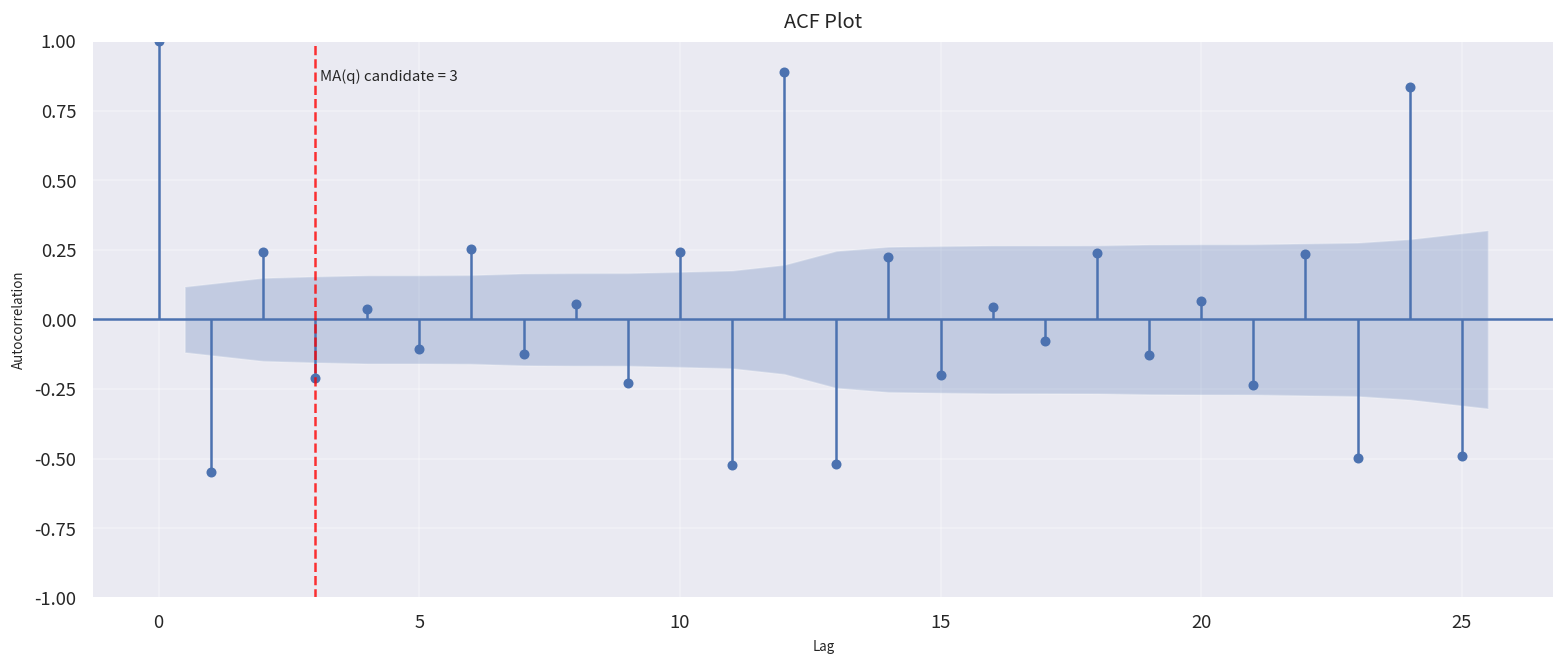

In [ ]:
# 1) 그래프 초기화
width_px = 1600          # 그래프 가로 크기
height_px = 700          # 그래프 세로 크기
rows = 1                # 그래프 행 수
cols = 1                # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2-1) ACF Plot 그리기 -> ax 파라미터 필수
plot_acf(df2['전국'], ax=ax)

# 2-2) MA(q) 후보 시각화
ax.axvline(
    x=q_candidate,
    linestyle="--",
    linewidth=1.5,
    alpha=0.8,
    color="red"
)

ax.text(
    q_candidate + 0.1,
    ax.get_ylim()[1] * 0.9,
    f"MA(q) candidate = {q_candidate}",
    fontsize=9,
    verticalalignment="top"
)

# 3) 그래프 꾸미기
ax.set_title("ACF Plot", fontsize=12, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)   # 배경 격자 표시

# 4) 출력
plt.tight_layout()         # 여백 제거
plt.show()                 # 그래프 화면 출력
plt.close()                # 그래프 작업 종료


> q는 3

#### 1.PACF 직접 계산하기

In [ ]:
# 1) PACF 계산
pacf_vals = pacf(df2['전국'])
threshold = 2 / np.sqrt(len(df2['전국']))

# 2) 결과표 생성
df_pacf = DataFrame({
    "lag": np.arange(len(pacf_vals)),
    "pacf": pacf_vals,
})

# 3) 유의성 판단
df_pacf["abs_pacf"] = df_pacf["pacf"].abs()
df_pacf["significant"] = df_pacf["abs_pacf"] > threshold

# 4) 보기 좋게 정리
df_pacf["pacf"] = df_pacf["pacf"].round(3)
df_pacf["abs_pacf"] = df_pacf["abs_pacf"].round(3)
df_pacf["threshold"] = round(threshold, 3)

# 5) lag=0 제외
df_pacf_result = df_pacf.query("lag > 0").reset_index(drop=True)

# 6) 연속 유의 구간 계산
df_pacf_result["prev_significant"] = df_pacf_result["significant"].shift(1)

df_pacf_result["cut_candidate"] = (
    (df_pacf_result["prev_significant"] == True) &
    (df_pacf_result["significant"] == False)
)

df_pacf_result[["lag", "pacf", "significant", "cut_candidate"]]

df_pacf_result


,lag,pacf,abs_pacf,significant,threshold,prev_significant,cut_candidate
0,1,-0.549,0.549,True,0.121,NaN,False
1,2,-0.081,0.081,False,0.121,True,True
2,3,-0.160,0.160,True,0.121,False,False
3,4,-0.202,0.202,True,0.121,True,False
4,5,-0.266,0.266,True,0.121,True,False
5,6,0.109,0.109,False,0.121,True,True
6,7,0.105,0.105,False,0.121,False,False
7,8,-0.017,0.017,False,0.121,False,False
8,9,-0.303,0.303,True,0.121,False,False
9,10,0.056,0.056,False,0.121,True,True


In [ ]:

p_candidate = (
    df_pacf_result
        .loc[df_pacf_result["cut_candidate"], "lag"]
        .min() - 1
)

p_candidate


np.int64(1)

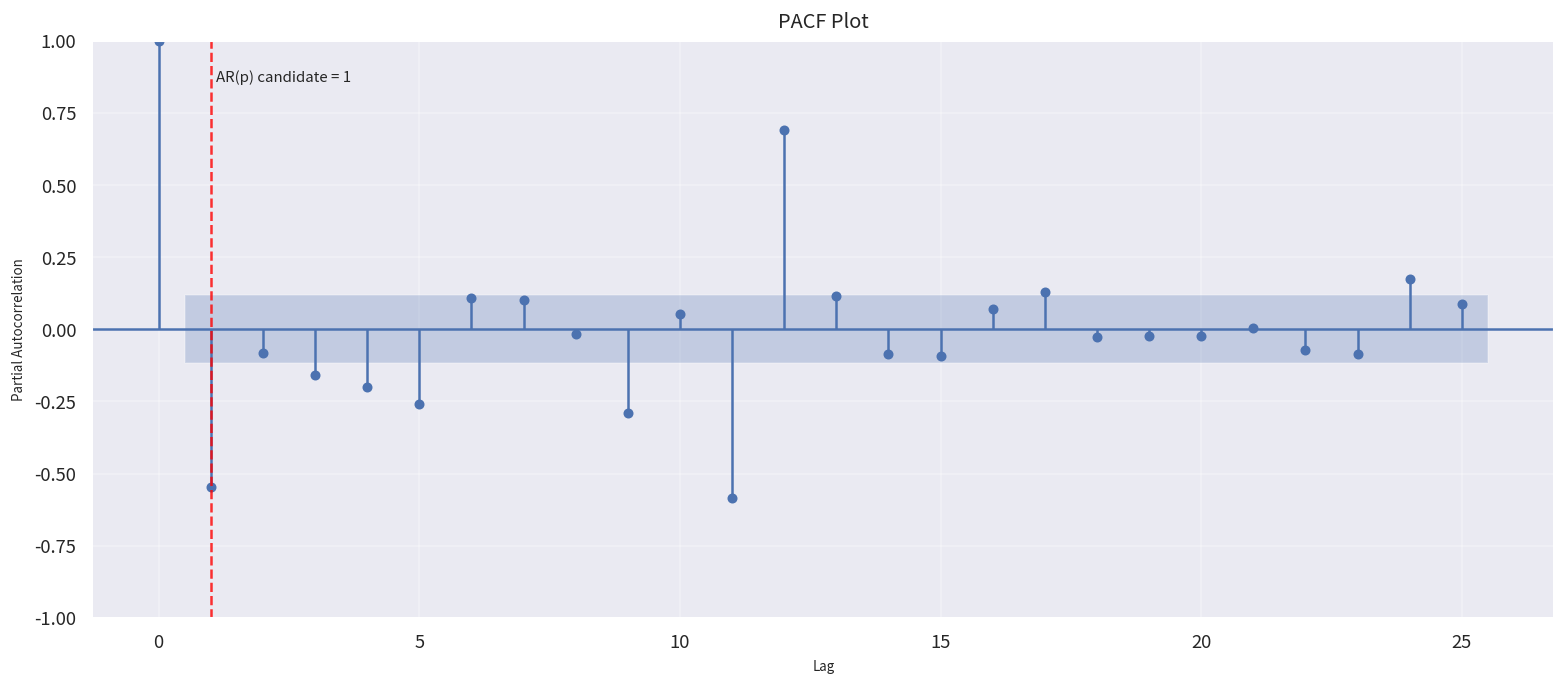

In [ ]:
# 1) 그래프 초기화
width_px = 1600
height_px = 720
rows = 1
cols = 1

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2-1) PACF Plot 그리기
plot_pacf(df2['전국'], ax=ax)

# 2-2) AR(p) 후보 시각화
ax.axvline(
    x=p_candidate,
    linestyle="--",
    linewidth=1.5,
    alpha=0.8,
    color="red"
)

ax.text(
    p_candidate + 0.1,
    ax.get_ylim()[1] * 0.9,
    f"AR(p) candidate = {p_candidate}",
    fontsize=9,
    verticalalignment="top"
)

# 3) 그래프 꾸미기
ax.set_title("PACF Plot", fontsize=12, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Partial Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


> p 는 1

### ARIMA 분석 수행 

In [ ]:
p = 1   #PACF
d = 1
q = 2   #ACF

results = []  # 결과 저장용

for x in range(0, p + 1):
    for y in range(0, d + 1):
        for z in range(0, q + 1):
            try:
                # model = ARIMA(df2['평균기온(℃)'], order=(x, y, z))

                # 12개월 단위 계절성 추가
                model = ARIMA(
                    df2['전국'],
                    order=(x, y, z),
                    seasonal_order=(x, y, z, 12)
                )

                fit = model.fit()

                results.append({
                    'p': x,
                    'd': y,
                    'q': z,
                    'AIC': fit.aic,
                    'BIC': fit.bic
                })

            except Exception as e:
                # 수렴 실패 / 모델 오류는 건너뜀
                continue

df_results = DataFrame(results)

# 방법 1 - 합산 점수 고려
# df_results['AIC_rank'] = df_results['AIC'].rank()
# df_results['BIC_rank'] = df_results['BIC'].rank()
# df_results['rank_sum'] = df_results['AIC_rank'] + df_results['BIC_rank']
# best_model = df_results.sort_values('rank_sum').iloc[0]
# best_model

# 방법 2 - 보수적 기준: BIC 우선 + AIC 보조
best_model = df_results.sort_values(['BIC', 'AIC']).iloc[0]
best_model


c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\itwill\AppData\Local\P

p         0.000000
d         1.000000
q         2.000000
AIC    4478.368491
BIC    4496.210213
Name: 5, dtype: float64

#### 도출된 값으로 최종모형 만들기

In [ ]:
best_order = (
    int(best_model['p']),
    int(best_model['d']),
    int(best_model['q'])
)

s_best_order = (
    int(best_model['p']),
    int(best_model['d']),
    int(best_model['q']),
    6
)

final_model = ARIMA(
    df2['전국'],
    order=best_order,
    seasonal_order=s_best_order
)


#선택된 구조로 한번만, 깔끔하게 최종 학습!
final_fit = final_model.fit()

print(final_fit.summary())


c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\itwill\AppData\Local\P

                                    SARIMAX Results                                    
Dep. Variable:                              전국   No. Observations:                  275
Model:             ARIMA(0, 1, 2)x(0, 1, 2, 6)   Log Likelihood               -2397.275
Date:                         Thu, 18 Dec 2025   AIC                           4804.550
Time:                                 18:11:54   BIC                           4822.505
Sample:                                      0   HQIC                          4811.761
                                         - 275                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4493      0.094    -15.472      0.000      -1.633      -1.266
ma.L2          0.4493      0.064      6.973      0.000     

### 분석 결과 활용

In [ ]:
df2.head()

,전국,rolling3,rolling6,rolling9
시점,,,,
2000년 02월,-4921.0,NaN,NaN,NaN
2000년 03월,3155.0,NaN,NaN,NaN
2000년 04월,-6820.0,-2862.000000,NaN,NaN
2000년 05월,-566.0,-1410.333333,NaN,NaN
2000년 06월,-5718.0,-4368.000000,NaN,NaN


In [ ]:

#모델이 학습 데이터에 대해 얼마나 잘 맞췄는지, 적합값을 확인하기 위한 준비 단계
df3 = df2.copy()
df3['pred'] = fit.fittedvalues  #훈련 데이터 구간에서 모델이 예측한 값들/ 모델이 과거 데이터를 보고 그떄의 값을 추청한 것
df3.head()

,전국,rolling3,rolling6,rolling9,pred
시점,,,,,
2000년 02월,-4921.0,NaN,NaN,NaN,0.000000
2000년 03월,3155.0,NaN,NaN,NaN,-3278.666890
2000년 04월,-6820.0,-2862.000000,NaN,NaN,166.996437
2000년 05월,-566.0,-1410.333333,NaN,NaN,-3366.936551
2000년 06월,-5718.0,-4368.000000,NaN,NaN,-1973.578488


#### 2. 이후 1년간의 추가적인 예측값을 생성
- 월단위 데이터이므로 12개의 추가 데이터 생성

In [ ]:
fc = fit.forecast(60)
fc

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


275    6971.397307
276   -4036.750162
277    2211.767773
278   -1644.470531
279    -859.807386
280   -1051.772266
281    1321.118123
282     664.661622
283     166.198892
284   -1054.686830
285   -1579.579665
286   -1941.451084
287    6801.116536
288   -4005.994666
289    2255.188792
290   -1553.936216
291    -782.591561
292    -969.176594
293    1259.137540
294     490.842202
295     136.914391
296    -970.284139
297   -1495.411634
298   -1968.729535
299    6839.077413
300   -3985.714789
301    2273.297135
302   -1540.602244
303    -768.970681
304    -956.652803
305    1282.838403
306     523.156681
307     157.123437
308    -959.614505
309   -1484.987530
310   -1949.485794
311    6852.845824
312   -3970.664962
313    2288.395886
314   -1525.222160
315    -753.702089
316    -941.368683
317    1297.154723
318     536.723367
319     171.629630
320    -944.369851
321   -1469.752376
322   -1934.990538
323    6867.764811
324   -3955.866904
325    2303.175831
326   -1510.476815
327    -738.

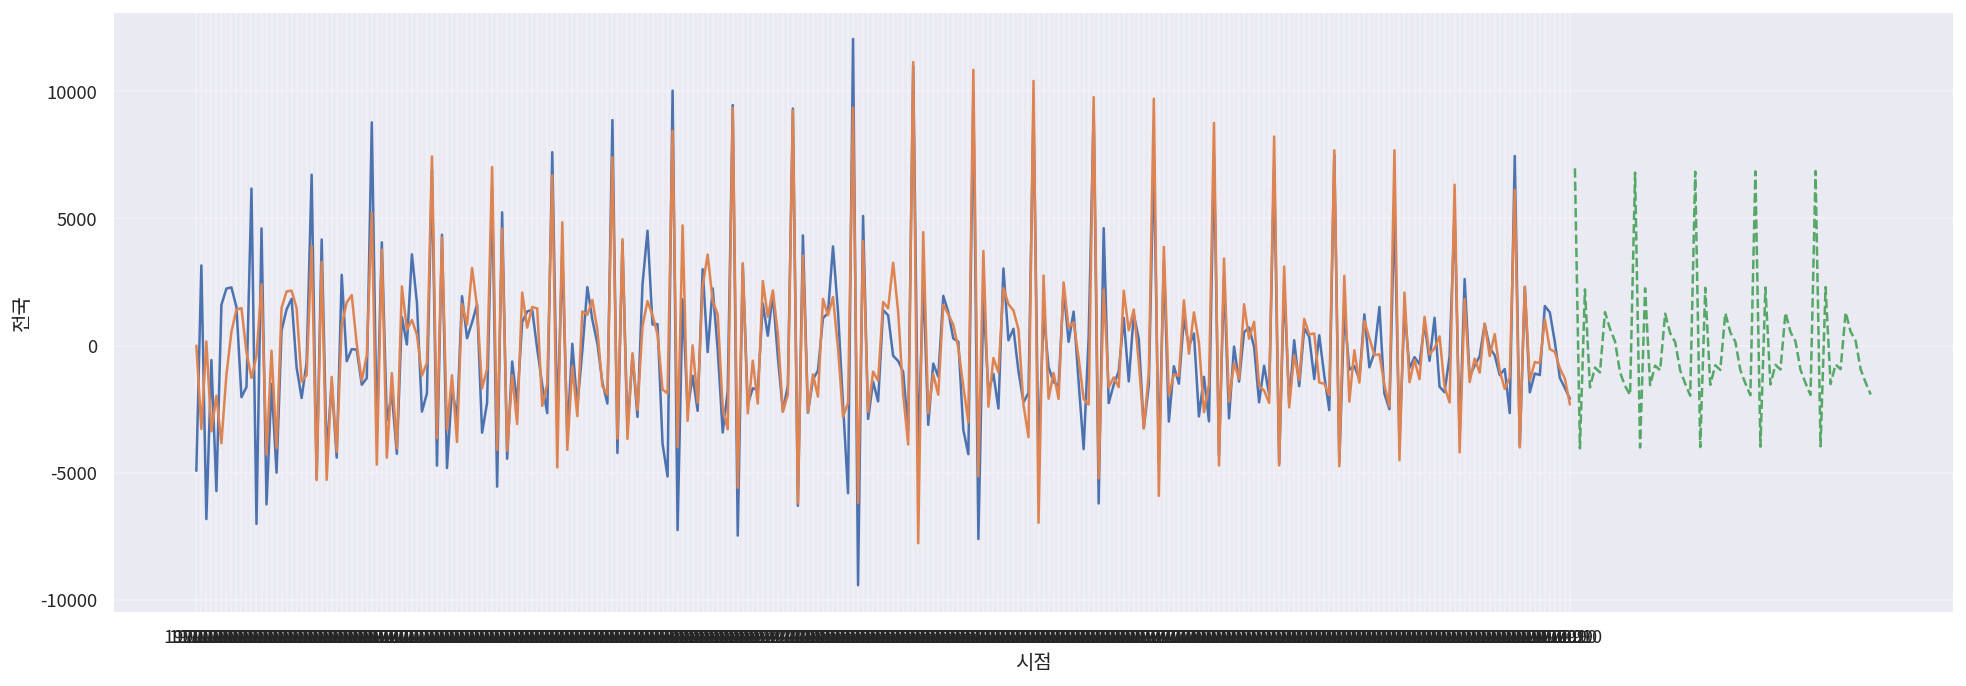

In [ ]:
# 1) 그래프 초기화
width_px = 2000           # 그래프 가로 크기
height_px = 720           # 그래프 세로 크기
rows = 1                 # 그래프 행 수
cols = 1                 # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LinePlot 그리기
# 관측치
sb.lineplot(data=df3, x=df3.index, y="전국")

# 예측치
sb.lineplot(data=df3, x=df3.index, y="pred")

# 이후 예측
sb.lineplot(x=fc.index, y=fc.values, linestyle="--")

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)    # 배경 격자 표시

# 그래프의 축이 날짜 형식일 경우 출력 날짜 포맷 지정
monthyearFmt = dates.DateFormatter("%Y.%m")
ax.xaxis.set_major_formatter(monthyearFmt)

# 4) 출력
plt.tight_layout()          # 여백 제거
plt.show()                  # 그래프 화면 출력
plt.close()                 # 그래프 작업 종료


### 분석 결과 해석
- 시계열 분석 결과 보고에서는 모형 구조 > 적합도 > 계수 해석 > 잔차 진단의 흐름이 가장 표준적

In [ ]:
#### 결과보고함수

In [ ]:
from pandas import DataFrame

def arima_report(fit, data, threshold=0.05):
    """
    SARIMAXResults 객체(fit)와 원본 데이터(data)를 받아
    모형 적합도 표(cdf),
    계수 요약 표(rdf),
    모형 요약 문장(result_report),
    모형 판정 문장(model_report),
    계수별 해석 문장(variable_reports)를 반환한다.
    """

    # ----------------------------
    # 모형 적합도 요약
    # ----------------------------
    cdf = DataFrame({
        "Log Likelihood": [fit.llf],
        "AIC": [fit.aic],
        "BIC": [fit.bic],
        "HQIC": [fit.hqic],
        "관측치 수": [fit.nobs],
    })

    # ----------------------------
    # 계수 테이블 구성
    # ----------------------------
    params = fit.params
    bse = fit.bse
    zvals = params / bse
    pvals = fit.pvalues
    conf = fit.conf_int()

    rows = []
    for name in params.index:
        p = pvals[name]
        stars = (
            "***" if p < 0.001 else
            "**" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )

        rows.append({
            "변수": name,
            "계수": params[name],
            "표준오차": bse[name],
            "z": f"{zvals[name]:.3f}{stars}",
            "p-value": p,
            "CI_lower": conf.loc[name, 0],
            "CI_upper": conf.loc[name, 1],
        })

    rdf = DataFrame(rows)

    # ----------------------------
    # 모형 요약 문장
    # ----------------------------
    result_report = (
        f"Log Likelihood = {fit.llf:.3f}, "
        f"AIC = {fit.aic:.3f}, "
        f"BIC = {fit.bic:.3f}."
    )

    # ----------------------------
    # 모형 판정 문장
    # ----------------------------
    model_report = (
        f"ARIMA{fit.model.order}×{fit.model.seasonal_order} 모형을 적합한 결과, "
        f"AIC {fit.aic:.3f}, BIC {fit.bic:.3f}로 나타났으며 "
        f"잔차의 자기상관은 Ljung-Box 검정에서 유의하지 않았다."
    )

    # ----------------------------
    # 계수별 해석 문장
    # ----------------------------
    variable_reports = []
    for _, row in rdf.iterrows():
        variable_reports.append(
            f"{row['변수']} 계수는 {row['계수']:.3f}로 "
            f"통계적으로 {'유의하다' if row['p-value'] < threshold else '유의하지 않다'} "
            f"(p {'<' if row['p-value'] < threshold else '>'} {threshold})."
        )

    return cdf, rdf, result_report, model_report, variable_reports


In [ ]:
cdf ,rdf,r,m,v = arima_report(final_fit,df2)
display(cdf)
display(rdf)
display(r)
display(m)
display(v)

,Log Likelihood,AIC,BIC,HQIC,관측치 수
0,-2397.274816,4804.549632,4822.504567,4811.761191,275


,변수,계수,표준오차,z,p-value,CI_lower,CI_upper
0,ma.L1,-1.449253e+00,9.366726e-02,-15.472***,5.332503e-54,-1.632837e+00,-1.265668e+00
1,ma.L2,4.492551e-01,6.443158e-02,6.973***,3.111549e-12,3.229715e-01,5.755386e-01
2,ma.S.L6,-1.267202e+00,5.505156e-02,-23.018***,3.045794e-117,-1.375101e+00,-1.159303e+00
3,ma.S.L12,4.360530e-01,5.312982e-02,8.207***,2.261955e-16,3.319205e-01,5.401855e-01
4,sigma2,3.258462e+06,3.697715e-08,88120957541897.531***,0.000000e+00,3.258462e+06,3.258462e+06


'Log Likelihood = -2397.275, AIC = 4804.550, BIC = 4822.505.'

'ARIMA(0, 1, 2)×(0, 1, 2, 6) 모형을 적합한 결과, AIC 4804.550, BIC 4822.505로 나타났으며 잔차의 자기상관은 Ljung-Box 검정에서 유의하지 않았다.'

['ma.L1 계수는 -1.449로 통계적으로 유의하다 (p < 0.05).',
 'ma.L2 계수는 0.449로 통계적으로 유의하다 (p < 0.05).',
 'ma.S.L6 계수는 -1.267로 통계적으로 유의하다 (p < 0.05).',
 'ma.S.L12 계수는 0.436로 통계적으로 유의하다 (p < 0.05).',
 'sigma2 계수는 3258462.182로 통계적으로 유의하다 (p < 0.05).']